In [ ]:
!git clone https://github.com/amir7d0/InfoGAN.git
!cp -r InfoGAN/infogan .

Cloning into 'InfoGAN'...
remote: Enumerating objects: 134, done.
remote: Counting objects: 100% (134/134), done.
remote: Compressing objects: 100% (89/89), done.
remote: Total 134 (delta 58), reused 115 (delta 42), pack-reused 0
Receiving objects: 100% (134/134), 21.88 KiB | 10.94 MiB/s, done.
Resolving deltas: 100% (58/58), done.


## Train InfoGAN Model

In [ ]:

import tensorflow as tf
import os

from infogan.models import get_discriminator_model, get_generator_model, get_recognition_model
from infogan.datasets import get_dataset
from infogan.infogan_model import InfoGAN
from infogan.config import config
from infogan.distributions import Uniform, Categorical
from infogan.utils import InfoGANMonitor, InfoGANCheckpoint, InfoGANCSVLogger

tf.config.run_functions_eagerly(True)


if __name__ == "__main__":
    log_dir = os.path.join(config.root_log_dir, config.dataset_name)
    checkpoint_dir = os.path.join(config.root_checkpoint_dir, config.dataset_name)
    os.makedirs(log_dir, exist_ok=True)
    os.makedirs(checkpoint_dir, exist_ok=True)

    # load dataset
    mnist_dataset = get_dataset(config.dataset_name, config.batch_size)
    dataset = mnist_dataset.get_dataset()

    # define latent codes specification
    latent_spec = {
        'noise-variables': [Uniform(62)],    # for `noise-variables` just specify one dist in list format
        'continuous-latent-codes': [Uniform(1), Uniform(1)],
        'discrete-latent-codes': [Categorical(10)]
    }
    noise_len = sum([sum([x.dim for x in xx]) for xx in latent_spec.values()])
    generator = get_generator_model([noise_len])
    discriminator = get_discriminator_model(mnist_dataset.image_shape)
    recognition = get_recognition_model([discriminator.output[1].shape[1]], latent_spec)

    info_gan = InfoGAN(
        generator=generator, discriminator=discriminator, recognition=recognition,
        latent_spec=latent_spec, discrete_reg_coeff=1.0, continuous_reg_coeff=1.0)

    ## Restore the latest checkpoint
    # checkpoint = tf.train.Checkpoint(info_gan)
    # checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))
    ## or
    # checkpoint = tf.train.Checkpoint(info_gan)
    # save_path = 'ckt/mnist/training_checkpoints-20'
    # checkpoint.restore(save_path)

    info_gan.compile(
        g_optimizer=tf.keras.optimizers.Adam(1e-3, 0.5),
        d_optimizer=tf.keras.optimizers.Adam(2e-4, 0.5),
        loss_fn=tf.keras.losses.BinaryCrossentropy(from_logits=True)
    )
    monitor_cbk = InfoGANMonitor(latent_spec=latent_spec, log_dir=log_dir)
    checkpoint_cbk = InfoGANCheckpoint(checkpoint_dir)
    csv_logger_cbk = InfoGANCSVLogger(filename=f'{config.root_log_dir}/{config.dataset_name}-loss.csv',
                                      separator=",", append=True)

    info_gan.fit(dataset, epochs=config.epochs, callbacks=[monitor_cbk, checkpoint_cbk, csv_logger_cbk])
    
    

Number of examples: 60000
Shape of the images in the dataset: (28, 28)


## Generate Images

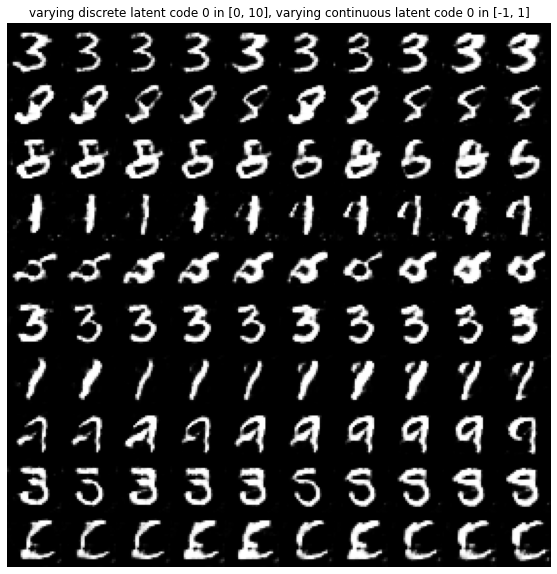

In [ ]:
plot_test(info_gan.generator, latent_spec, (0, [0, 10]), (0, [-1, 1]))

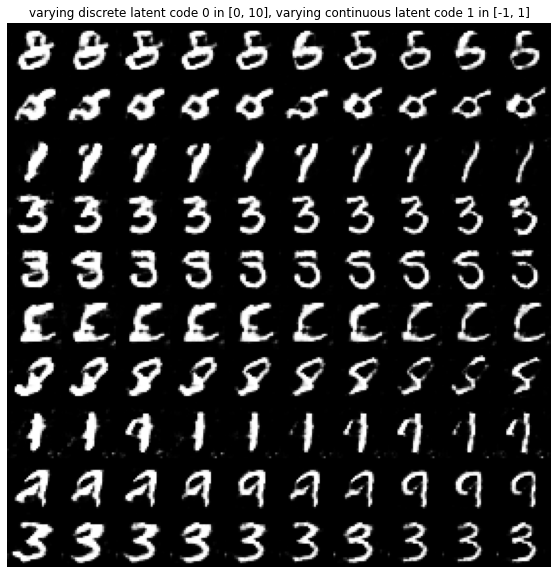

In [ ]:
from infogan.utils import plot_test

plot_test(info_gan.generator, latent_spec, (0, [0, 10]), (1, [-1, 1]))

## Restore Trained Model

In [ ]:

import tensorflow as tf
import os

from infogan.models import get_discriminator_model, get_generator_model, get_recognition_model
from infogan.datasets import get_dataset
from infogan.infogan_model import InfoGAN
from infogan.config import config
from infogan.distributions import Uniform, Categorical
from infogan.utils import InfoGANMonitor, InfoGANCheckpoint, InfoGANCSVLogger

tf.config.run_functions_eagerly(True)


if __name__ == "__main__":
    log_dir = os.path.join(config.root_log_dir, config.dataset_name)
    checkpoint_dir = os.path.join(config.root_checkpoint_dir, config.dataset_name)
    os.makedirs(log_dir, exist_ok=True)
    os.makedirs(checkpoint_dir, exist_ok=True)

    # load dataset
    mnist_dataset = get_dataset(config.dataset_name, config.batch_size)
    dataset = mnist_dataset.get_dataset()

    # define latent codes specification
    latent_spec = {
        'noise-variables': [Uniform(62)],    # for `noise-variables` just specify one dist in list format
        'continuous-latent-codes': [Uniform(1), Uniform(1)],
        'discrete-latent-codes': [Categorical(10)]
    }
    noise_len = sum([sum([x.dim for x in xx]) for xx in latent_spec.values()])
    generator = get_generator_model([noise_len])
    discriminator = get_discriminator_model(mnist_dataset.image_shape)
    recognition = get_recognition_model([discriminator.output[1].shape[1]], latent_spec)

    info_gan = InfoGAN(
        generator=generator, discriminator=discriminator, recognition=recognition,
        latent_spec=latent_spec, discrete_reg_coeff=1.0, continuous_reg_coeff=1.0)

    ## Restore the latest checkpoint
    checkpoint = tf.train.Checkpoint(info_gan)
    checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))
    ## or
    # checkpoint = tf.train.Checkpoint(info_gan)
    # save_path = 'ckt/mnist/training_checkpoints-20'
    # checkpoint.restore(save_path)

    # if you want to train the model you should compile restored model and fit
    # info_gan.compile(
    #     g_optimizer=tf.keras.optimizers.Adam(1e-3, 0.5),
    #     d_optimizer=tf.keras.optimizers.Adam(2e-4, 0.5),
    #     loss_fn=tf.keras.losses.BinaryCrossentropy(from_logits=True)
    # )
    # monitor_cbk = InfoGANMonitor(latent_spec=latent_spec, log_dir=log_dir)
    # checkpoint_cbk = InfoGANCheckpoint(checkpoint_dir)
    # csv_logger_cbk = InfoGANCSVLogger(filename=f'{config.root_log_dir}/{config.dataset_name}-loss.csv',
    #                                   separator=",", append=True)

    # info_gan.fit(dataset, epochs=config.epochs, callbacks=[monitor_cbk, checkpoint_cbk, csv_logger_cbk])
    
    